## Instacart market basket analysis

### Import statements

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from pandas import Series, DataFrame 

%matplotlib inline

# Reading datasets from external csv file
print('loading product prior')
pprior = pd.read_csv('order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading product train')
ptrain = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])
print('loaded completely')

/home/amaresh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading product prior
loading product train
loading orders
loading products
loaded completely


### Processing data to get train and test sets

In [2]:
# Replacing the nan values with 0 (implies it is 1st order) day_prior_order in orders and converting to type int
# because as it is first order there are no previous order dates
value = 0
orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(value)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)
orders.isnull().sum()                                                


# Computing the user details (finding the details of purchase made by each user by user_id)

# Joining orders with product prior to get product id 
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
pprior = pprior.join(orders, on='order_id', rsuffix='_')
pprior.drop('order_id_', inplace=True, axis=1)

# Joining orders with product train to get product id 
print('add order info to train')
ptrain = ptrain.join(orders, on='order_id', rsuffix='_')
ptrain.drop('order_id_', inplace=True, axis=1)

# Reduce the user id to 500 to train 
limits = 500
ptrain = ptrain.loc[ptrain['user_id'] <= limits]

# Reduce the user id to 500 to test 
pprior = pprior.loc[pprior['user_id'] <= limits]

user = pd.DataFrame()

# Total number of order by users
user['total_products'] = pprior.groupby('user_id').size().astype(np.int16)

# All product_id of products purchased by users
user['products_all'] = pprior.groupby('user_id')['product_id'].apply(set)

# Distinct no of product user purchased
user['total_distinct_items'] = (user.products_all.map(len)).astype(np.int16)

# Finding average days between subsequent orders placed by same user from orders dataframe and no of orders
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

# Joining the user with usr by user_id
user = user.join(usr)
del usr
user['average_basket'] = (user.total_products / user.nb_orders).astype(np.float32)
print('number of users:', user.shape[0])

# Computing the products details 

print('computing product features')
prods = pd.DataFrame()
prods['orders'] = pprior.groupby(pprior.product_id).size().astype(np.int32)
prods['reorders'] = pprior['reordered'].groupby(pprior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

# finding the total number of products
max_products = products['product_id'].max()
print('max product_id value :',max_products)
print('max of user_id :',limits)

# Computing userXproduct details from user and product details previously obtained

print('compute userXproduct features this is long...')

# encoding the user_id and product_id into user_product because 50000 is the max value of product_id
pprior['user_product'] = pprior.product_id + pprior.user_id * 50000
d= dict()
for row in pprior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,row.order_id,row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1, max(d[z][1], (row.order_id)),
                d[z][2] + row.add_to_cart_order)
        
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

del pprior


# Seperation of train and test orderset from orders to make model and predict

print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

ptrain = ptrain[['order_id','product_id','add_to_cart_order','reordered']]
ptrain.set_index(['order_id', 'product_id'], inplace=True, drop=False)
train_orders = train_orders.loc[train_orders['user_id']<= limits]
test_orders = test_orders.loc[test_orders['user_id']<= limits]


### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%100 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = user.products_all[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in ptrain.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(user.nb_orders)
    df['user_total_items'] = df.user_id.map(user.total_products)
    df['total_distinct_items'] = df.user_id.map(user.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(user.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(user.average_basket)
    
    print('order related features')
    df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 50000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    return (df, labels)


# Gathering required features and labels for given train_orders 
train_x, train_y = features(train_orders, labels_given=True)

# Features used for training the model
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate','dow','UP_orders_since_last','UP_delta_hour_vs_last'] 

add order info to priors
add order info to train
number of users: 500
computing product features
max product_id value : 49688
max of user_id : 500
compute userXproduct features this is long...
to dataframe (less memory)
user X product f 32233
split orders : train, test
build candidate list
order row 100
order row 200
order row 300
user related features
order related features
product related features
user_X_product related features


### Splitting training data into train and test sets

In [3]:
#Now splitting our dataset into test and train 

from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test=train_test_split(train_x,train_y,test_size=.25)

### Xg-boost 

In [7]:
#The data is stored in a DMatrix object 
#label is used to define our outcome variable
dtrain=xgb.DMatrix(x_train,label=y_train)
dtest=xgb.DMatrix(x_test)


#setting parameters for xgboost
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}


#training our model 
num_round=50
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 

stop = datetime.now()

#Execution time of the model 
execution_time_xgb = stop-start 
execution_time_xgb

#datetime.timedelta( , , ) representation => (days , seconds , microseconds) 
#now predicting our model on test set 

ypred=xg.predict(dtest) 
ypred

#Converting probabilities into 1 or 0  
for i in range(0,len(ypred)): 
    if ypred[i]>=.5:       # setting threshold to .5 
       ypred[i]=1 
    else: 
       ypred[i]=0  

    #calculating accuracy of our model 
from sklearn.metrics import accuracy_score 
accuracy_xgb = accuracy_score(y_test,ypred) 
accuracy_xgb

0.8978102189781022

### Light gradient boosting

In [8]:
train_data=lgbm.Dataset(x_train,label=y_train)

#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

#training our model using light gbm
num_round=50
start=datetime.now()
lgbms=lgbm.train(param,train_data,num_round)
stop=datetime.now()

#Execution time of the model
execution_time_lgbm = stop-start

#predicting on test set
ypred2=lgbms.predict(x_test)
ypred2[0:5]  # showing first 5 predictions

#converting probabilities into 0 or 1
for i in range(0,len(ypred2)):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    
    else:  
       ypred2[i]=0
    
    
#calculating accuracy
accuracy_lgbm = accuracy_score(ypred2,y_test)
accuracy_lgbm

0.89642927599131983

### Naive bayes

In [9]:
from sklearn.naive_bayes import GaussianNB

# Training
gnb = GaussianNB()
start=datetime.now()
gnb.fit(x_train, y_train)
stop = datetime.now()

# Predicting
ypred3 = gnb.predict(x_test)

#Execution time of the model
execution_time_gnb = stop-start

# Accuracy measure
accuracy_gnb = accuracy_score(ypred3,y_test)
accuracy_gnb

0.8875517853620043

### Support vector machine

In [10]:
from sklearn import svm

# linear svm model for classifier
svmc = svm.SVC()

# Training
start=datetime.now()
svmc.fit(x_train,y_train)
stop = datetime.now()

# Predicting
ypred4 = svmc.predict(x_test)

#Execution time of the model
execution_time_svm = stop-start

# Accuracy measure
accuracy_svm = accuracy_score(ypred4,y_test)
accuracy_svm

0.89051094890510951

### Decision tree

In [11]:
from sklearn import tree

dst = tree.DecisionTreeClassifier()

# Training
start=datetime.now()
dst.fit(x_train,y_train)
stop = datetime.now()

# Predicting
y_pred5 = dst.predict(x_test)

#Execution time of the model
execution_time_dst = stop-start

# Accuracy measure
accuracy_dst = accuracy_score(y_pred5,y_test)
accuracy_dst

0.84987176957979882

### Performance of individual methods

In [12]:
from sklearn.metrics import roc_auc_score

#calculating roc_auc_score for xgboost
auc_xgb =  roc_auc_score(y_test,ypred)

#calculating roc_auc_score for light gbm
auc_lgbm = roc_auc_score(y_test,ypred2)

#calculating roc_auc_score for navie bayes
auc_nb = roc_auc_score(y_test,ypred3)

#calculating roc_auc_score for support vector machine
auc_svm = roc_auc_score(y_test,ypred4)

#calculating roc_auc_score for decision tree
auc_dst = roc_auc_score(y_test,y_pred5)

auc_lgbm_comparison_dict = {'accuracy score':(accuracy_lgbm,accuracy_xgb,accuracy_gnb,accuracy_svm,accuracy_dst),
                            'auc score':(auc_lgbm,auc_xgb,auc_nb,auc_svm,auc_dst),
                            'execution time':(execution_time_lgbm,execution_time_xgb,
                                              execution_time_gnb,execution_time_svm,execution_time_dst)}

#Creating a dataframe ‘comparison_df’ for comparing the performance of Lightgbm and xgb. 
comparison_df = DataFrame(auc_lgbm_comparison_dict) 
comparison_df.index= ['LightGbm','XgBoost','NaiveBayes','Svm','DecisionTree'] 
comparison_df

,accuracy score,auc score,execution time
LightGbm,0.896429,0.562583,00:00:00.248345
XgBoost,0.897810,0.563358,00:00:00.732622
NaiveBayes,0.887552,0.509400,00:00:00.007970
Svm,0.890511,0.500000,00:00:43.029196
DecisionTree,0.849872,0.613085,00:00:00.254040


### Tuninig the parameters for Xgboost

In [7]:
# Formating datasets for xgboost.

xgdmat = xgb.DMatrix(train_x[f_to_use], train_y)

# Parameters that we are going to tune.
params = {
    'max_depth':6,
    'min_child_weight': 3,
    'eta':0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.99,
    'objective':'binary:logistic',
    'alpha':2e-05,
    'lambda':10
}


params['eval_metric'] = "mae"

num_boost_round = 2000

cv_results = xgb.cv(
    params,
    xgdmat,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

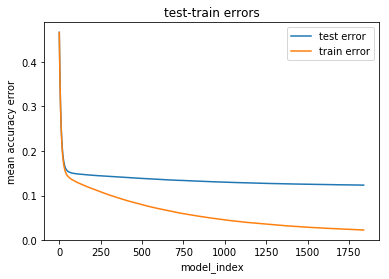

In [8]:
cv_results['index_col'] = cv_results.index
plt.plot(cv_results['index_col'],cv_results['test-mae-mean'],label = "test error")
plt.plot(cv_results['index_col'],cv_results['train-mae-mean'],label = "train error")

# naming the x axis
plt.xlabel('model_index')
# naming the y axis
plt.ylabel('mean accuracy error')
# giving a title to my graph
plt.title('test-train errors')

# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

In [12]:
gridsearch_params = [
    (max_depth, min_child_weight,subsample,colsample,eta)
    for max_depth in range(3,8)
    for min_child_weight in range(7,12)
    for subsample in [i/10. for i in range(6,9)]
    for colsample in [i/10. for i in range(6,9)]
    for eta in [.3, .2, .1, .05, .01, .005]
]

In [13]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight,subsample,colsample,eta in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={},subsample={}, colsample={},CV with eta={}".format(
                             max_depth,min_child_weight,subsample,colsample,eta))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['subsample'] = subsample
    params['colsample'] = colsample
    params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        params,
        xgdmat,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )

    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.6,CV with eta=0.3
	MAE 0.1457886 for 40 rounds
CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.6,CV with eta=0.2
	MAE 0.14561320000000003 for 63 rounds
CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.6,CV with eta=0.1
	MAE 0.14604699999999998 for 109 rounds
CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.6,CV with eta=0.05
	MAE 0.1452114 for 216 rounds
CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.6,CV with eta=0.01
	MAE 0.14621040000000002 for 998 rounds
CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.6,CV with eta=0.005
	MAE 0.1565346 for 999 rounds
CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.3
	MAE 0.1457886 for 40 rounds
CV with max_depth=3, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.2
	MAE 0.14561320000000003 for 63 rounds
CV with max_depth=3, min_child_weight=7,

	MAE 0.1464228 for 118 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.6, colsample=0.8,CV with eta=0.05
	MAE 0.1455132 for 217 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.6, colsample=0.8,CV with eta=0.01
	MAE 0.14728780000000002 for 890 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.6, colsample=0.8,CV with eta=0.005
	MAE 0.15702339999999998 for 999 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.3
	MAE 0.14462000000000003 for 43 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.2
	MAE 0.14374099999999998 for 107 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.1
	MAE 0.14605300000000002 for 107 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.05
	MAE 0.1452274 for 237 rounds
CV with max_depth=3, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.01
	MAE 0.1460756 for 996 ro

	MAE 0.1563286 for 999 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.7, colsample=0.8,CV with eta=0.3
	MAE 0.1457686 for 40 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.7, colsample=0.8,CV with eta=0.2
	MAE 0.14415879999999998 for 78 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.7, colsample=0.8,CV with eta=0.1
	MAE 0.1468036 for 107 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.7, colsample=0.8,CV with eta=0.05
	MAE 0.1453694 for 248 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.7, colsample=0.8,CV with eta=0.01
	MAE 0.146221 for 996 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.7, colsample=0.8,CV with eta=0.005
	MAE 0.1563286 for 999 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.3
	MAE 0.144889 for 43 rounds
CV with max_depth=3, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.2
	MAE 0.14607560000000003 for 43 rounds
CV with max_depth=3, min_child_w

	MAE 0.146679 for 106 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.7,CV with eta=0.05
	MAE 0.14483039999999997 for 285 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.7,CV with eta=0.01
	MAE 0.146535 for 996 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.7,CV with eta=0.005
	MAE 0.156114 for 999 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.8,CV with eta=0.3
	MAE 0.14611259999999998 for 43 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.8,CV with eta=0.2
	MAE 0.144082 for 80 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.8,CV with eta=0.1
	MAE 0.146679 for 106 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.8,CV with eta=0.05
	MAE 0.14483039999999997 for 285 rounds
CV with max_depth=3, min_child_weight=10,subsample=0.8, colsample=0.8,CV with eta=0.01
	MAE 0.146535 for 996 rounds
CV with max_de

	MAE 0.1564314 for 999 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.3
	MAE 0.1440692 for 42 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.2
	MAE 0.1467016 for 42 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.1
	MAE 0.14505240000000003 for 118 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.05
	MAE 0.14466640000000003 for 231 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.01
	MAE 0.1457608 for 998 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.7,CV with eta=0.005
	MAE 0.1564314 for 999 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.8,CV with eta=0.3
	MAE 0.1440692 for 42 rounds
CV with max_depth=4, min_child_weight=7,subsample=0.6, colsample=0.8,CV with eta=0.2
	MAE 0.1467016 for 42 rounds
CV with max_depth=4, min_child

	MAE 0.14438440000000002 for 130 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.05
	MAE 0.144501 for 248 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.01
	MAE 0.145446 for 996 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.6,CV with eta=0.005
	MAE 0.1557582 for 999 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.7,CV with eta=0.3
	MAE 0.13995600000000002 for 93 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.7,CV with eta=0.2
	MAE 0.1466238 for 44 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.7,CV with eta=0.1
	MAE 0.14438440000000002 for 130 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.7,CV with eta=0.05
	MAE 0.144501 for 248 rounds
CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.7,CV with eta=0.01
	MAE 0.145446 for 996 rounds
CV with max_depth=4,

	MAE 0.15617140000000002 for 999 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.3
	MAE 0.1444264 for 43 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.2
	MAE 0.1437098 for 78 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.1
	MAE 0.14503480000000002 for 129 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.05
	MAE 0.1443452 for 247 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.01
	MAE 0.14560040000000002 for 996 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.6,CV with eta=0.005
	MAE 0.1555396 for 999 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.7,CV with eta=0.3
	MAE 0.1444264 for 43 rounds
CV with max_depth=4, min_child_weight=9,subsample=0.8, colsample=0.7,CV with eta=0.2
	MAE 0.1437098 for 78 rounds
CV with max_depth=4,

	MAE 0.1445804 for 285 rounds
CV with max_depth=4, min_child_weight=10,subsample=0.8, colsample=0.8,CV with eta=0.01
	MAE 0.1459128 for 996 rounds
CV with max_depth=4, min_child_weight=10,subsample=0.8, colsample=0.8,CV with eta=0.005
	MAE 0.1558276 for 999 rounds
CV with max_depth=4, min_child_weight=11,subsample=0.6, colsample=0.6,CV with eta=0.3
	MAE 0.1468082 for 40 rounds
CV with max_depth=4, min_child_weight=11,subsample=0.6, colsample=0.6,CV with eta=0.2
	MAE 0.1481362 for 40 rounds
CV with max_depth=4, min_child_weight=11,subsample=0.6, colsample=0.6,CV with eta=0.1
	MAE 0.1465842 for 149 rounds
CV with max_depth=4, min_child_weight=11,subsample=0.6, colsample=0.6,CV with eta=0.05
	MAE 0.14635979999999998 for 216 rounds
CV with max_depth=4, min_child_weight=11,subsample=0.6, colsample=0.6,CV with eta=0.01
	MAE 0.14805059999999998 for 890 rounds
CV with max_depth=4, min_child_weight=11,subsample=0.6, colsample=0.6,CV with eta=0.005
	MAE 0.1579234 for 999 rounds
CV with max_depth

	MAE 0.14426239999999999 for 40 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.6, colsample=0.8,CV with eta=0.2
	MAE 0.1468246 for 41 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.6, colsample=0.8,CV with eta=0.1
	MAE 0.14519580000000004 for 118 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.6, colsample=0.8,CV with eta=0.05
	MAE 0.1445236 for 231 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.6, colsample=0.8,CV with eta=0.01
	MAE 0.1456584 for 998 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.6, colsample=0.8,CV with eta=0.005
	MAE 0.1564384 for 999 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.7, colsample=0.6,CV with eta=0.3
	MAE 0.1426162 for 44 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.7, colsample=0.6,CV with eta=0.2
	MAE 0.1419018 for 76 rounds
CV with max_depth=5, min_child_weight=7,subsample=0.7, colsample=0.6,CV with eta=0.1
	MAE 0.1443354 for 109 rounds
CV with max_depth=5, min_child

	MAE 0.1453674 for 996 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.7, colsample=0.7,CV with eta=0.005
	MAE 0.1556888 for 999 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.7, colsample=0.8,CV with eta=0.3
	MAE 0.14427660000000003 for 43 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.7, colsample=0.8,CV with eta=0.2
	MAE 0.14246160000000002 for 109 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.7, colsample=0.8,CV with eta=0.1
	MAE 0.14386040000000003 for 162 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.7, colsample=0.8,CV with eta=0.05
	MAE 0.1445816 for 237 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.7, colsample=0.8,CV with eta=0.01
	MAE 0.1453674 for 996 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.7, colsample=0.8,CV with eta=0.005
	MAE 0.1556888 for 999 rounds
CV with max_depth=5, min_child_weight=8,subsample=0.8, colsample=0.6,CV with eta=0.3
	MAE 0.1435654 for 43 rounds
CV with max_dept

	MAE 0.14369839999999998 for 170 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.7,CV with eta=0.05
	MAE 0.144009 for 247 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.7,CV with eta=0.01
	MAE 0.1455692 for 996 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.7,CV with eta=0.005
	MAE 0.1554994 for 999 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.8,CV with eta=0.3
	MAE 0.143984 for 43 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.8,CV with eta=0.2
	MAE 0.14574479999999998 for 44 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.8,CV with eta=0.1
	MAE 0.14369839999999998 for 170 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.8,CV with eta=0.05
	MAE 0.144009 for 247 rounds
CV with max_depth=5, min_child_weight=9,subsample=0.8, colsample=0.8,CV with eta=0.01
	MAE 0.1455692 for 996 rounds
CV with max_depth=5

	MAE 0.1579258 for 999 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.7,CV with eta=0.3
	MAE 0.1468082 for 40 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.7,CV with eta=0.2
	MAE 0.1481362 for 40 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.7,CV with eta=0.1
	MAE 0.14660820000000002 for 146 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.7,CV with eta=0.05
	MAE 0.1461246 for 217 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.7,CV with eta=0.01
	MAE 0.1474278 for 993 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.7,CV with eta=0.005
	MAE 0.1579258 for 999 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.8,CV with eta=0.3
	MAE 0.1468082 for 40 rounds
CV with max_depth=5, min_child_weight=11,subsample=0.6, colsample=0.8,CV with eta=0.2
	MAE 0.1481362 for 40 rounds
CV with max_depth=5, min_child_w

	MAE 0.1439702 for 237 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.6,CV with eta=0.01
	MAE 0.1447464 for 993 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.6,CV with eta=0.005
	MAE 0.155287 for 999 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.7,CV with eta=0.3
	MAE 0.142122 for 44 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.7,CV with eta=0.2
	MAE 0.14256059999999998 for 78 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.7,CV with eta=0.1
	MAE 0.1442204 for 109 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.7,CV with eta=0.05
	MAE 0.1439702 for 237 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.7,CV with eta=0.01
	MAE 0.1447464 for 993 rounds
CV with max_depth=6, min_child_weight=7,subsample=0.7, colsample=0.7,CV with eta=0.005
	MAE 0.155287 for 999 rounds
CV with max_depth=6, min_child_weight=

	MAE 0.146336 for 43 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.6,CV with eta=0.1
	MAE 0.1419242 for 247 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.6,CV with eta=0.05
	MAE 0.14276300000000003 for 284 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.6,CV with eta=0.01
	MAE 0.1449044 for 998 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.6,CV with eta=0.005
	MAE 0.1551558 for 999 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.7,CV with eta=0.3
	MAE 0.1436154 for 44 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.7,CV with eta=0.2
	MAE 0.146336 for 43 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.7,CV with eta=0.1
	MAE 0.1419242 for 247 rounds
CV with max_depth=6, min_child_weight=8,subsample=0.8, colsample=0.7,CV with eta=0.05
	MAE 0.14276300000000003 for 284 rounds
CV with max_depth=6, min_child

	MAE 0.1554984 for 999 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.6,CV with eta=0.3
	MAE 0.14579879999999998 for 40 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.6,CV with eta=0.2
	MAE 0.147811 for 43 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.6,CV with eta=0.1
	MAE 0.14688099999999998 for 115 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.6,CV with eta=0.05
	MAE 0.1460106 for 217 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.6,CV with eta=0.01
	MAE 0.1474994 for 890 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.6,CV with eta=0.005
	MAE 0.157539 for 999 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.7,CV with eta=0.3
	MAE 0.14579879999999998 for 40 rounds
CV with max_depth=6, min_child_weight=10,subsample=0.6, colsample=0.7,CV with eta=0.2
	MAE 0.147811 for 43 rounds
CV with max_dep

	MAE 0.14660820000000002 for 146 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.6, colsample=0.8,CV with eta=0.05
	MAE 0.1461246 for 217 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.6, colsample=0.8,CV with eta=0.01
	MAE 0.1474278 for 993 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.6, colsample=0.8,CV with eta=0.005
	MAE 0.1579258 for 999 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.7, colsample=0.6,CV with eta=0.3
	MAE 0.1454942 for 43 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.7, colsample=0.6,CV with eta=0.2
	MAE 0.1441712 for 109 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.7, colsample=0.6,CV with eta=0.1
	MAE 0.1453914 for 162 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.7, colsample=0.6,CV with eta=0.05
	MAE 0.145776 for 236 rounds
CV with max_depth=6, min_child_weight=11,subsample=0.7, colsample=0.6,CV with eta=0.01
	MAE 0.14653600000000003 for 996 rounds
CV with max_depth=

	MAE 0.142122 for 44 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.7, colsample=0.8,CV with eta=0.2
	MAE 0.14256059999999998 for 78 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.7, colsample=0.8,CV with eta=0.1
	MAE 0.1442204 for 109 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.7, colsample=0.8,CV with eta=0.05
	MAE 0.14362599999999998 for 272 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.7, colsample=0.8,CV with eta=0.01
	MAE 0.144766 for 993 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.7, colsample=0.8,CV with eta=0.005
	MAE 0.1552866 for 999 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.8, colsample=0.6,CV with eta=0.3
	MAE 0.14370480000000002 for 44 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.8, colsample=0.6,CV with eta=0.2
	MAE 0.1414072 for 78 rounds
CV with max_depth=7, min_child_weight=7,subsample=0.8, colsample=0.6,CV with eta=0.1
	MAE 0.14416299999999999 for 109 rounds
CV with max_

	MAE 0.1448836 for 997 rounds
CV with max_depth=7, min_child_weight=8,subsample=0.8, colsample=0.7,CV with eta=0.005
	MAE 0.1551502 for 999 rounds
CV with max_depth=7, min_child_weight=8,subsample=0.8, colsample=0.8,CV with eta=0.3
	MAE 0.1436154 for 44 rounds
CV with max_depth=7, min_child_weight=8,subsample=0.8, colsample=0.8,CV with eta=0.2
	MAE 0.146336 for 43 rounds
CV with max_depth=7, min_child_weight=8,subsample=0.8, colsample=0.8,CV with eta=0.1
	MAE 0.1414424 for 284 rounds
CV with max_depth=7, min_child_weight=8,subsample=0.8, colsample=0.8,CV with eta=0.05
	MAE 0.14283700000000002 for 284 rounds
CV with max_depth=7, min_child_weight=8,subsample=0.8, colsample=0.8,CV with eta=0.01
	MAE 0.1448836 for 997 rounds
CV with max_depth=7, min_child_weight=8,subsample=0.8, colsample=0.8,CV with eta=0.005
	MAE 0.1551502 for 999 rounds
CV with max_depth=7, min_child_weight=9,subsample=0.6, colsample=0.6,CV with eta=0.3
	MAE 0.1458516 for 40 rounds
CV with max_depth=7, min_child_weight=

	MAE 0.14688099999999998 for 115 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.7,CV with eta=0.05
	MAE 0.1460106 for 217 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.7,CV with eta=0.01
	MAE 0.1474994 for 890 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.7,CV with eta=0.005
	MAE 0.157539 for 999 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.8,CV with eta=0.3
	MAE 0.14579879999999998 for 40 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.8,CV with eta=0.2
	MAE 0.147811 for 43 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.8,CV with eta=0.1
	MAE 0.14688099999999998 for 115 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.8,CV with eta=0.05
	MAE 0.1460106 for 217 rounds
CV with max_depth=7, min_child_weight=10,subsample=0.6, colsample=0.8,CV with eta=0.01
	MAE 0.1474994 for 890 rounds
CV with ma

	MAE 0.1568386 for 999 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.7,CV with eta=0.3
	MAE 0.1454942 for 43 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.7,CV with eta=0.2
	MAE 0.1441712 for 109 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.7,CV with eta=0.1
	MAE 0.1453914 for 162 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.7,CV with eta=0.05
	MAE 0.145776 for 236 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.7,CV with eta=0.01
	MAE 0.14653600000000003 for 996 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.7,CV with eta=0.005
	MAE 0.1568386 for 999 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.8,CV with eta=0.3
	MAE 0.1454942 for 43 rounds
CV with max_depth=7, min_child_weight=11,subsample=0.7, colsample=0.8,CV with eta=0.2
	MAE 0.1441712 for 109 rounds
CV with max_depth=7, min_child_

### Best parameters

In [30]:
#CV with max_depth=4, min_child_weight=8,subsample=0.7, colsample=0.7,CV with eta=0.3
params['max_depth'] = 4
params['min_child_weight'] = 8
params['subsample'] = 0.7
params['colsample'] = 0.7
params['eta'] = 0.3
params

{'alpha': 2e-05,
 'colsample': 0.7,
 'colsample_bytree': 0.99,
 'eta': 0.3,
 'eval_metric': 'mae',
 'lambda': 10,
 'max_depth': 4,
 'min_child_weight': 8,
 'objective': 'binary:logistic',
 'subsample': 0.7}

### Accuracy after parameter tuning

In [31]:
num_round=50
from datetime import datetime 
xg=xgb.train(params,dtrain,num_round) 

ypred=xg.predict(dtest) 
ypred

#Converting probabilities into 1 or 0  
for i in range(0,len(ypred)): 
    if ypred[i]>=0.5:       # setting threshold to .5 
       ypred[i]=1 
    else: 
       ypred[i]=0  

#Calculating accuracy of our model 
accuracy_xgb = accuracy_score(y_test,ypred) 
accuracy_xgb

0.89840205168672327